___
<img style="float: left; margin: 30px 15px 15px 15px;" src="https://d33wubrfki0l68.cloudfront.net/4ec62c1c925a380c912ddad740d18554c6822a11/fabe4/img/sponsors/iteso-university.png" width="300" height="500" />
    
    
# Modelado de pronóstico de series de tiempo.

**Nombres:**
- Kaleb Azael Avila Padilla
- Axel Cabrera Jaramillo
- Manuel Alejandro Murguía Orantes

**Expediente**:
- 724405
- 730793
- 739360

**Fecha:** 09 de mayo del 2024.

**Profesor:** Oscar David Jaramillo Zuluaga.
    
**Link Github**: https://github.com/jaramillooo/proyecto_modulo1

## Proyecto Final

### Proyecto Final - Guía.
> Se especifican los componentes básicos que deberá tener cada proyecto. El proyecto debe ser un problema que utilice datos reales, ya sea de una empresa física real o de alguna página de internet que proporcione bases de datos confiables. Con la información obtenida, se pretende utilizar todas las herramientas vistas durante el curso para la correcta modelación y simulación del cierto problema con ciertas variables de interés.

> De la base seleccionada debe de poder aplicarse cada uno de las tres secciones del curso.
> 1. Predicción de series de tiempo lineal (SARIMAX).  
> 2. Predicción de series de tiempo no lineal (MLP, CNN, LSTM, etc).
> 3. Clasificación de series de tiempo. Si la base de datos no tiene información suficiente para poder realizar clasificación, se puede utilizar otra base de datos diferente para aplicar las técnicas vistas para clasificar series de tiempo

___
## 1. Entregable.
Los trabajos deben tener los siguientes componentes básicos.

### 1.1 Título del trabajo.
> Debe describir el trabajo.

### 1.2 Objetivos.
> - Se refieren a los propósitos por los cuales se hace el trabajo.
> - Deben ser **concretos, evaluables y verificables.**
> - Deben ser escritos en infinitivo.
> #### 1.1 Objetivo general.
>  - Fin último de estudio. Se formula atendiendo el propósito global del trabajo. No presenta detalles.
>  - Se orienta a la totalidad del trabajo. Tiene que ver con el título del trabajo.
> #### 1.2 Objetivos específicos
>  - De forma detallada describen cada una de los componentes del trabajo.
>  - En conjunto garantizan la consecución del objetivo general.

Referencia:
- https://es.slideshare.net/rosbur/metodologia-objetivos-generales-y-especficos

### 1.3 Definición del problema.
> Se debe describir en una cuartilla máximo cuál es el escenario de negocio que se va a modelar, identificar cuáles son los supuestos que defines en el negocio y cuáles son los "nodos" o "escenarios" que identificas necesarios simular y porqué. Debes elaborar un diagrama de inicio a fin, identificando los "nodos" o "escenarios" a simular.

### 1.4 Nodos y variables que se decidieron simular y porqué
> En este apartado el objetivo es identificar los problemas que se van a abordar, para examinar la factibilidad y viabilidad de la simulación de los nodos escogidos. Posteriormente se debe de argumentar del porqué de los nodos escogidos.

### 1.5 Obtención de bases de datos
> El tercer paso del proyecto es indicar de dónde se obtendrán las bases de datos, que indican como se han comportado las variables que identificaste en tu proceso de negocio que vas a simular. En esta investigación debes haber encontrado información propia de la empresa, organización o institución que vas a simular y otra parte de la información debe provenir de investigación que realices en fuentes de información públicas o privadas como las que tiene SECOBI, ahí normalmente y dependiendo del problema elegido, se investigan variables económicas, como tasas de interés, inflación, tipo de cambio, etc., de varios años, por poner un ejemplo.

### 1.6 Visualización de resultados de simulación.
> Para cada uno de los temas del curso, realizar la estimación y predicción de errores de los algoritmos propuestos. Al final luego de obtener los resultados de cada tema realizar una comparación de los resultados lineales y no lineales y concluir los distintos resultados.

### 1.7 Conclusiones.
> Mucho cuidado, las conclusiones no son cualquier cosa. Se debe concluir respecto a los objetivos planteados de acuerdo a los resultados obtenidos.

### 1.8 Referencias.
> Citar (en formato APA) la bibliografía utilizada.

# Daily Demand Forecasting Orders

### [Link del Dataset](https://archive.ics.uci.edu/dataset/409/daily+demand+forecasting+orders).

Variables:
- Week of the month	Feature	Integer	(first, second, third, fourth or fifth week) -> {1.0, 2.0, 3.0, 4.0, 5.0}
- Day of the week (Monday to Friday) -> {2.0, 3.0, 4.0, 5.0, 6.0}
- Non-urgent order
- Urgent order
- Order type A
- Order type B
- Order type C
- Fiscal sector orders
- Orders from the traffic controller sector
- Banking orders (1)
- Banking orders (2)
- Banking orders (3)

Total_orders -> Target


## Objetivo:
El hacer un forecast del dataset para poder ver si es factible el usar algoritmos de ML para el uso empresarial y para un futuro nuestro poder usar el proyecto como portafolio, así como el poner a prueba todo lo aprendido en la clase de Modelos no lineales.

En la primera parte, el analizar de manera correcta cómo una serie de tiempo se puede hacer una predicción a futuro de una variable objetivo, también el usar diferentes modelos vistos en clase ya sea el CNN, MLP o los dos juntos.

## Definición del problema:
Nosotros vimos cómo en muchos negocios, en especial los de supermercados o los de e-commerce, necesitan saber cómo podrían ser sus ventas a futuro o cómo se podría ver cuántas ventas o pedidos a futuro puedan tener, ya sea para conseguir más producto o pedir menos de alguno, o hasta para poder hacer planes de negocio, como el poner ofertas en las semanas de menos ventas o en los meses donde casi no hay ventas, también el si los días de menos ventas tomarlos libres o dar esos días de vacaciones al personal, así que sí, es un experimento que puede ayudar a futuro a muchas empresas, en especial a PYMES aquí en Guadalajara o hasta a nosotros si algún día tenemos planeado hacer algo parecido.

In [ ]:
pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import timedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import MSTL
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")


In [ ]:
# dataset
daily_demand_forecasting_orders = fetch_ucirepo(id=409)
X = daily_demand_forecasting_orders.data.features
y = daily_demand_forecasting_orders.data.targets
print(daily_demand_forecasting_orders.metadata),print(daily_demand_forecasting_orders.variables)

{'uci_id': 409, 'name': 'Daily Demand Forecasting Orders', 'repository_url': 'https://archive.ics.uci.edu/dataset/409/daily+demand+forecasting+orders', 'data_url': 'https://archive.ics.uci.edu/static/public/409/data.csv', 'abstract': 'The dataset was collected during 60 days, this is a real database of a brazilian logistics company.', 'area': 'Business', 'tasks': ['Regression'], 'characteristics': ['Time-Series'], 'num_instances': 60, 'num_features': 12, 'feature_types': ['Integer'], 'demographics': [], 'target_col': ['Total orders'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2016, 'last_updated': 'Thu Mar 21 2024', 'dataset_doi': '10.24432/C5BC8T', 'creators': ['Ricardo Ferreira', 'Andrea Martiniano', 'Arthur Ferreira', 'Aleister Ferreira', 'Renato Sassi'], 'intro_paper': {'title': 'Study on Daily Demand Forecasting Orders using Artificial Neural Network', 'authors': 'R. P. Ferreira, Andréa Martiniano, Arthur Arruda Leal 

(None, None)

In [ ]:
X.head()

,Week of the month,Day of the week,Non-urgent order,Urgent order,Order type A,Order type B,Order type C,Fiscal sector orders,Orders from the traffic controller sector,Banking orders (1),Banking orders (2),Banking orders (3)
0,1,4,316.307,223.270,61.543,175.586,302.448,0.000,65556,44914,188411,14793
1,1,5,128.633,96.042,38.058,56.037,130.580,0.000,40419,21399,89461,7679
2,1,6,43.651,84.375,21.826,25.125,82.461,1.386,11992,3452,21305,14947
3,2,2,171.297,127.667,41.542,113.294,162.284,18.156,49971,33703,69054,18423
4,2,3,90.532,113.526,37.679,56.618,116.220,6.459,48534,19646,16411,20257


Despues de la obtención de los datos vamos a hacer nuestra variable de tiempo para poder trabajar en nuestros analísis y modelos.

In [ ]:
X['Datetime'] = pd.to_datetime((X['Week of the month'] - 1) * 7 + X['Day of the week'] - 2, unit='W', origin='2022-01-01')
# adjust the date range to 60 days
X['Datetime'] = X['Datetime'] - pd.Timedelta(days=7)
X.drop(['Week of the month', 'Day of the week'], axis=1, inplace=True)
ds = X.copy()
X.set_index('Datetime', inplace=True)

In [ ]:
X.dtypes

Non-urgent order                             float64
Urgent order                                 float64
Order type A                                 float64
Order type B                                 float64
Order type C                                 float64
Fiscal sector orders                         float64
Orders from the traffic controller sector      int64
Banking orders (1)                             int64
Banking orders (2)                             int64
Banking orders (3)                             int64
dtype: object

Vermos las ordenes que hay dentro del data set y de ahí sumar todas para tomarla como la variable objetivo.

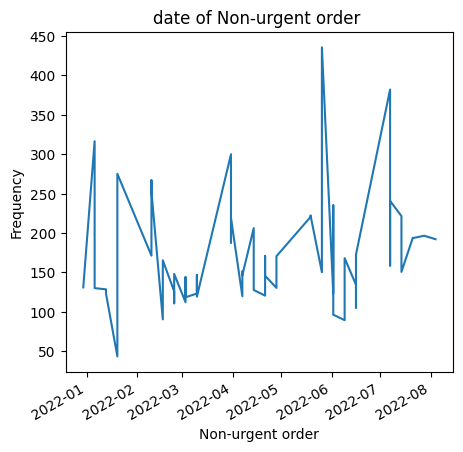

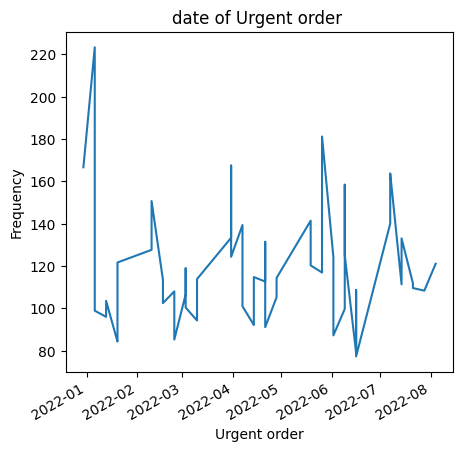

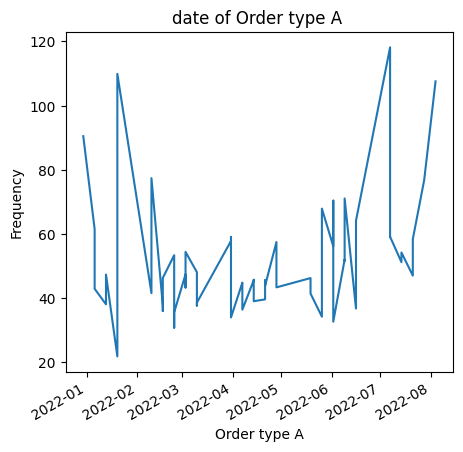

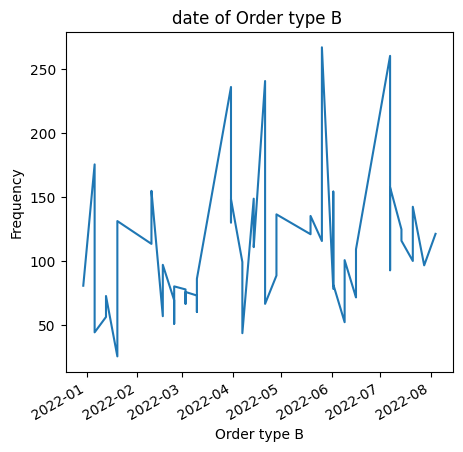

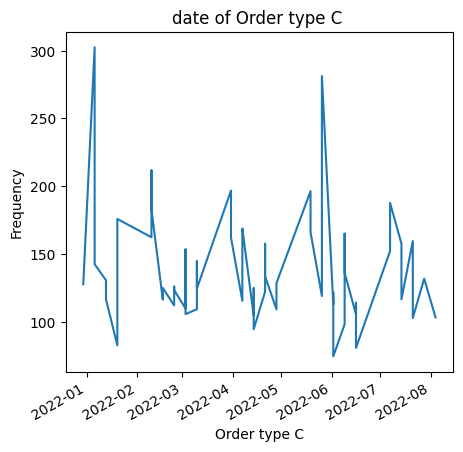

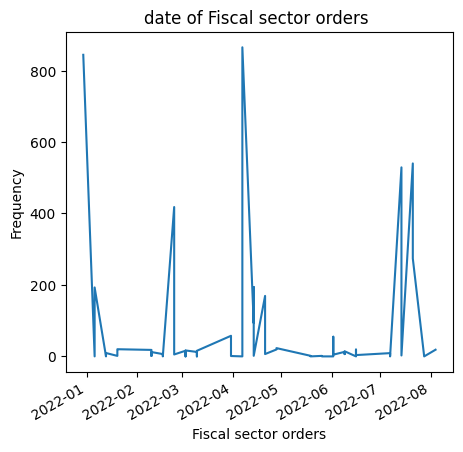

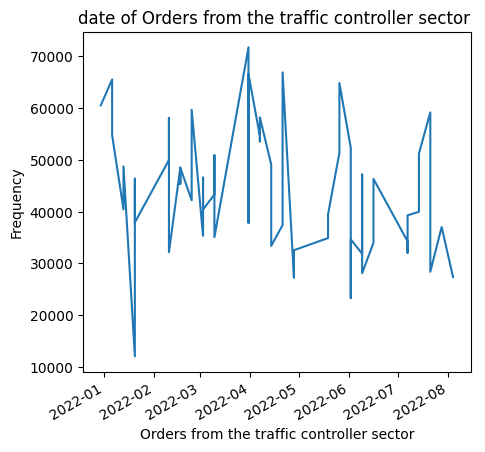

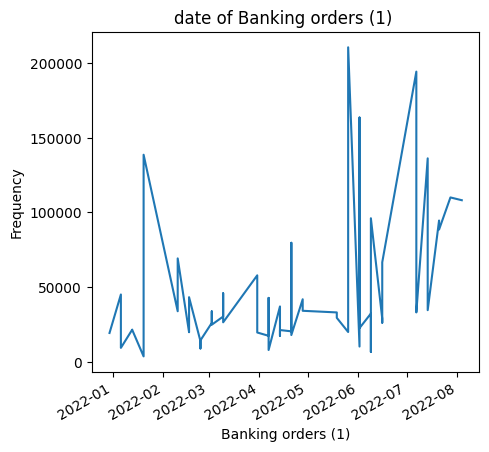

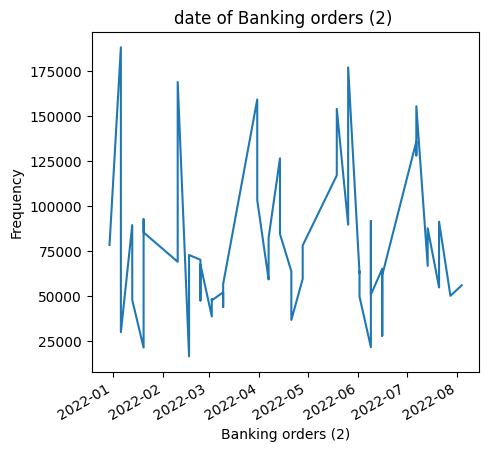

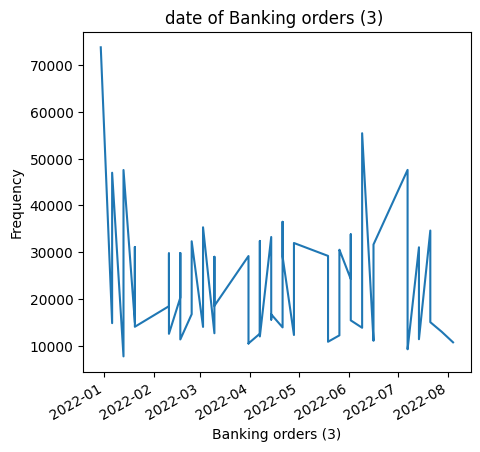

In [ ]:
columns_to_plot = [col for col in X.columns if col != 'Datetime']
for col in columns_to_plot:
    plt.figure(figsize=(5, 5))
    X[col].plot()
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.title(f"date of {col} ")
    plt.show()

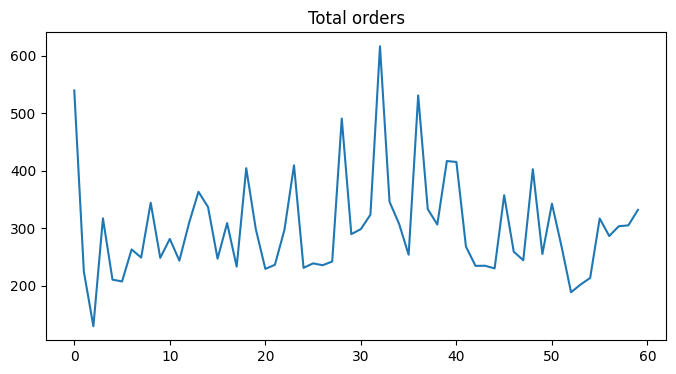

In [ ]:
y['Total orders'].plot(kind='line', figsize=(8, 4), title='Total orders')
plt.gca().spines[['top', 'right']].set_visible(True)

In [ ]:
_ = pd.DataFrame({
    'Datetime': ds['Datetime'],
    'Total orders': y['Total orders']
})
data = _.set_index('Datetime')
data.head(10)

,Total orders
Datetime,
2022-01-06,539.577
2022-01-13,224.675
2022-01-20,129.412
2022-02-10,317.120
2022-02-17,210.517
2022-02-24,207.364
2022-03-03,263.043
2022-03-10,248.958
2022-03-31,344.291


Vamos a analízar nuestros datos para ver si son estacionarios o no y de ahí pasar a más analisis de estos para ver como funcionarian mejor con los modelos.

<Axes: xlabel='Datetime'>

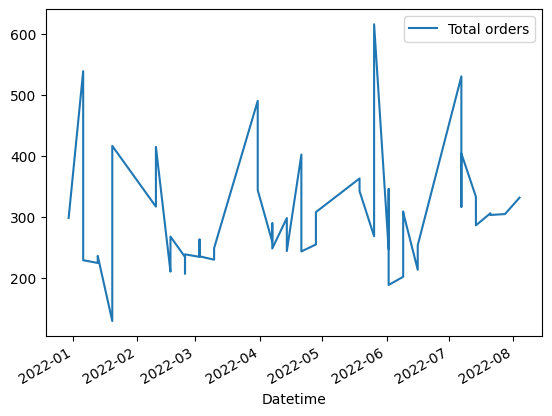

In [ ]:
data.plot()

Hicimos un resample de los datos para que nos diera la freciencia por semanas de los datos para poder trabajar y analisarlos mejor.

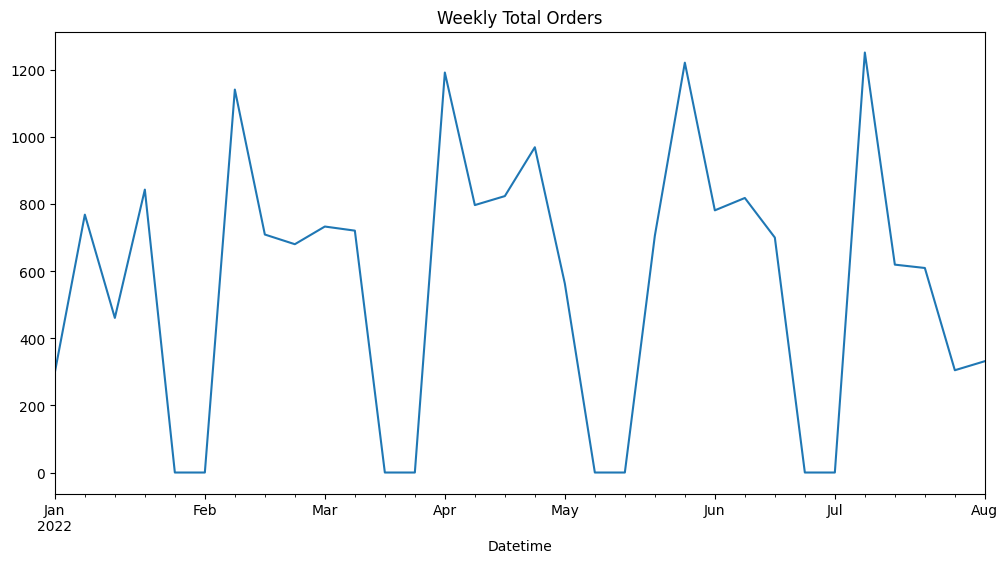

In [ ]:
days = data.resample('W')['Total orders'].sum()
days.plot(figsize=(12, 6))
plt.title('Weekly Total Orders')
plt.show()

In [ ]:
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from io import BytesIO

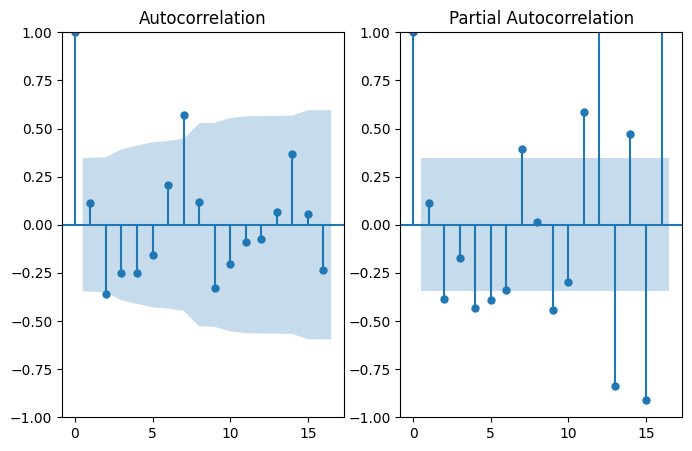

In [ ]:
# 1. Graficar ACF y PACF
f = plt.figure(figsize=(8,5))

ax1 = f.add_subplot(121)

plot_acf(days, ax=ax1)

ax2 = f.add_subplot(122)
plot_pacf(days, ax=ax2, method='ols')

plt.show()

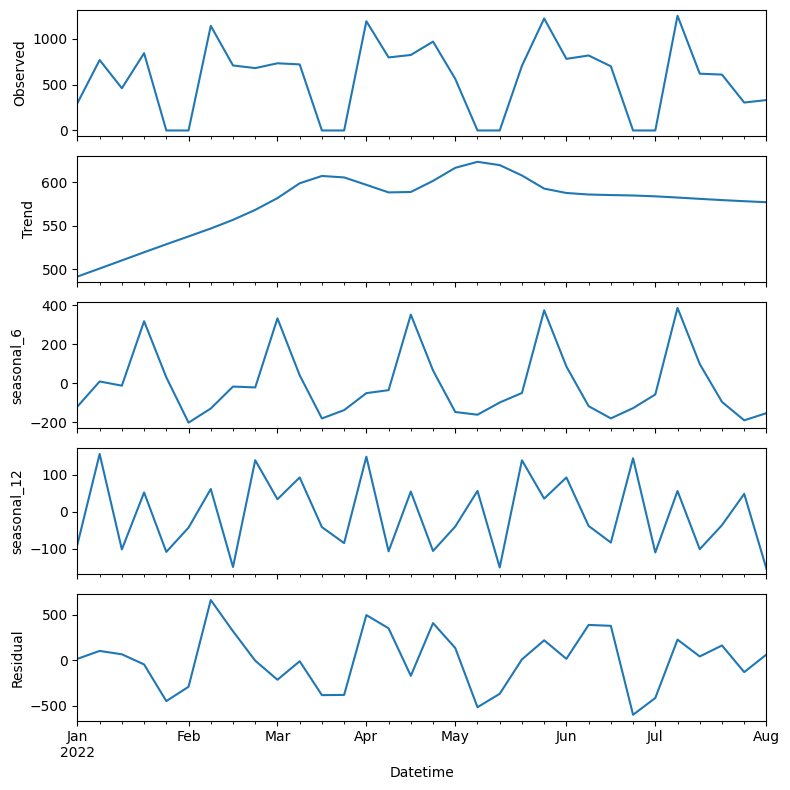

In [ ]:
# Función para análisis de estacionalidad
from statsmodels.tsa.seasonal import MSTL
import matplotlib.pyplot as plt

data1 = days.copy()
periods_seasonality = (6, 12)

stl_kwargs = {"seasonal_deg": 0}
model = MSTL(data1, periods=periods_seasonality, stl_kwargs=stl_kwargs)
res2 = model.fit()

# Gráfica de descomposición
fig, ax = plt.subplots(5, 1, sharex=True, figsize=(8, 8))

res2.observed.plot(ax=ax[0])
ax[0].set_ylabel('Observed')

res2.trend.plot(ax=ax[1])
ax[1].set_ylabel('Trend')

res2.seasonal[f'seasonal_{periods_seasonality[0]}'].plot(ax=ax[2])
ax[2].set_ylabel(f'seasonal_{periods_seasonality[0]}')

res2.seasonal[f'seasonal_{periods_seasonality[1]}'].plot(ax=ax[3])
ax[3].set_ylabel(f'seasonal_{periods_seasonality[1]}')

res2.resid.plot(ax=ax[4])
ax[4].set_ylabel('Residual')

fig.tight_layout()

In [ ]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

    if (dftest[1] <= 0.05) & (dftest[4]['5%'] > dftest[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [ ]:
adf_test(days)

Results of Dickey-Fuller Test:
Test Statistic                 -1.507899
p-value                         0.529600
#Lags Used                     10.000000
Number of Observations Used    21.000000
Critical Value (1%)            -3.788386
Critical Value (5%)            -3.013098
Critical Value (10%)           -2.646397
dtype: float64
Non-stationary


In [ ]:
adf_test(days.diff().dropna())

Results of Dickey-Fuller Test:
Test Statistic                -8.537604e+00
p-value                        9.981672e-14
#Lags Used                     5.000000e+00
Number of Observations Used    2.500000e+01
Critical Value (1%)           -3.723863e+00
Critical Value (5%)           -2.986489e+00
Critical Value (10%)          -2.632800e+00
dtype: float64
Stationary


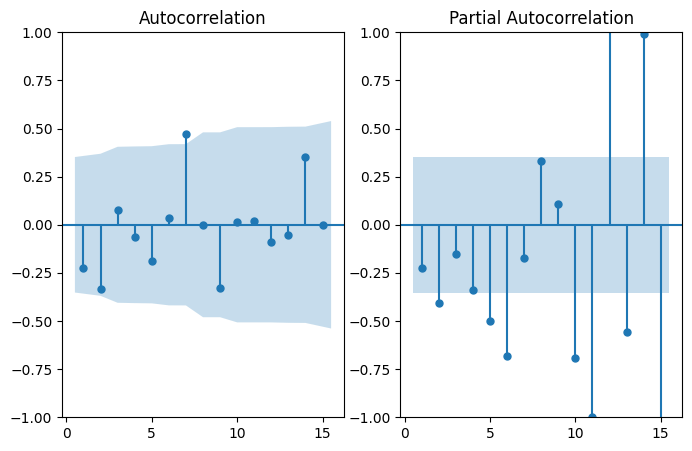

In [ ]:

def plot_acf_pacf(data, kwargs=dict()):
    f = plt.figure(figsize=(8,5))

    ax1 = f.add_subplot(121)

    plot_acf(data, zero=False, ax=ax1, **kwargs)

    ax2 = f.add_subplot(122)
    plot_pacf(data, zero=False, ax=ax2, method='ols', **kwargs)

    plt.show()

plot_acf_pacf(days.diff().dropna(), {'lags':15})

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
arima_model1 = ARIMA(days, order=(8, 2, 2))
model1 = arima_model1.fit()
print(model1.summary())

                               SARIMAX Results                                
Dep. Variable:           Total orders   No. Observations:                   32
Model:                 ARIMA(8, 2, 2)   Log Likelihood                -215.061
Date:                Wed, 08 May 2024   AIC                            452.123
Time:                        03:19:25   BIC                            467.536
Sample:                    01-02-2022   HQIC                           457.054
                         - 08-07-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9544      1.876     -0.509      0.611      -4.631       2.722
ar.L2         -0.8509      2.567     -0.331      0.740      -5.883       4.181
ar.L3         -0.6763      2.909     -0.232      0.8

<Axes: xlabel='Datetime'>

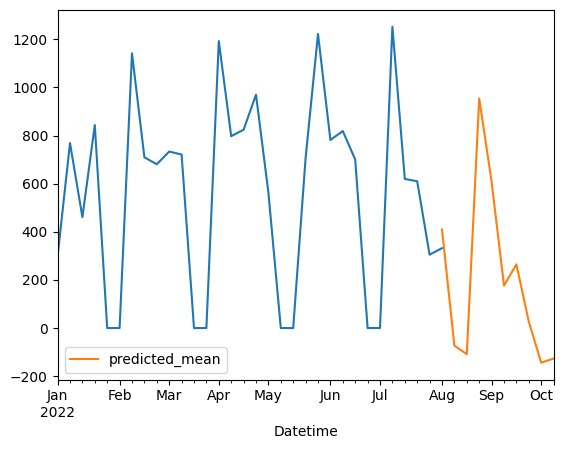

In [ ]:
y_h = model1.predict(start=31, end=40, dynamic=False).to_frame()

ax = days.plot()

y_h.plot(ax=ax)

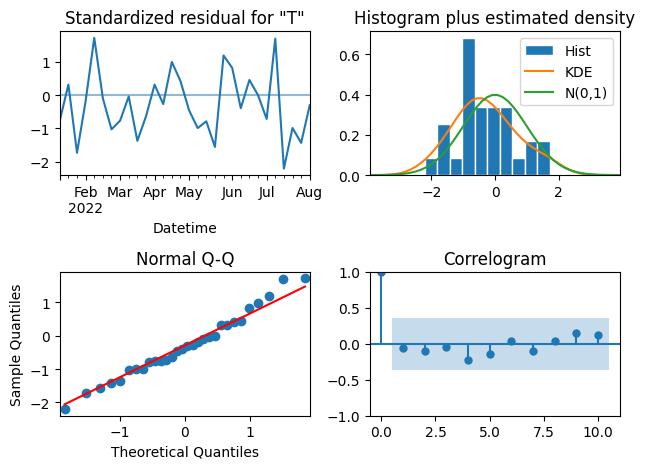

In [ ]:
model1.plot_diagnostics()
plt.tight_layout();

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 40.0 MB/s eta 0:00:00
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   32
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -234.227
Date:                Wed, 08 May 2024   AIC                            476.454
Time:                        03:19:49   BIC                            482.316
Sample:                    01-02-2022   HQIC                           478.397
                         - 08-07-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    693.2419    133.424      5.196      0.000     431.736     954.747
ar.L1          0.1542      0.192      0.801      0.4

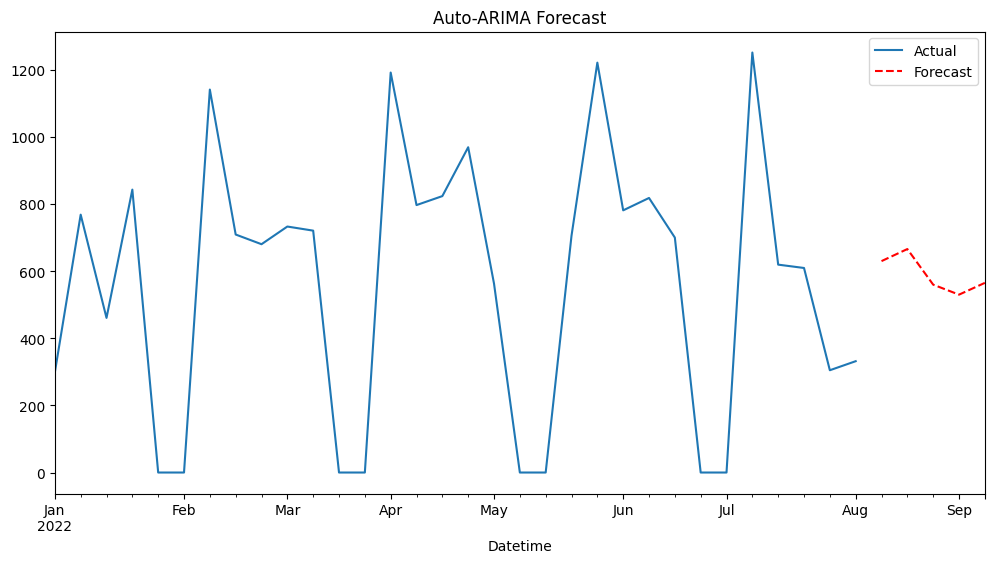

In [ ]:
import pandas as pd
!pip install pmdarima
import pmdarima as pm
from pmdarima import model_selection

model = pm.auto_arima(days, start_p=3, start_q=0, start_P=1, start_Q=1,
                     max_p=5, max_q=5, max_P=5, max_Q=5, seasonal=True,
                     stepwise=True, suppress_warnings=True, D=7, max_D=10,
                     error_action='ignore')
print(model.summary())
forecast = model.predict(n_periods=5)
days.plot(figsize=(12, 6), label='Actual')
forecast.plot(color='red', linestyle='--', label='Forecast')
plt.legend()
plt.title('Auto-ARIMA Forecast')
plt.show()

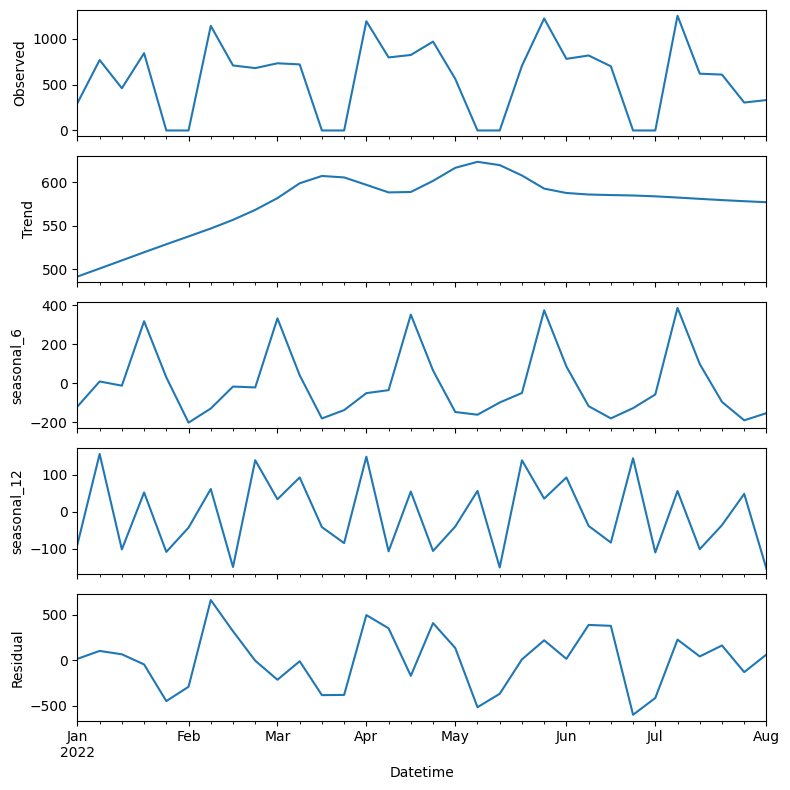

In [ ]:
# Función para análisis de estacionalidad
from statsmodels.tsa.seasonal import MSTL
import matplotlib.pyplot as plt

periods_seasonality = (6,12)

stl_kwargs = {"seasonal_deg": 0}
model = MSTL(days, periods=(periods_seasonality), stl_kwargs=stl_kwargs)
res2 = model.fit()

# Gráfica de descomposición
fig, ax = plt.subplots(5, 1, sharex=True, figsize=(8, 8))

res2.observed.plot(ax=ax[0])
ax[0].set_ylabel('Observed')

res2.trend.plot(ax=ax[1])
ax[1].set_ylabel('Trend')

res2.seasonal[f'seasonal_{periods_seasonality[0]}'].plot(ax=ax[2])
ax[2].set_ylabel(f'seasonal_{periods_seasonality[0]}')

res2.seasonal[f'seasonal_{periods_seasonality[1]}'].plot(ax=ax[3])
ax[3].set_ylabel(f'seasonal_{periods_seasonality[1]}')

res2.resid.plot(ax=ax[4])
ax[4].set_ylabel('Residual')

fig.tight_layout()

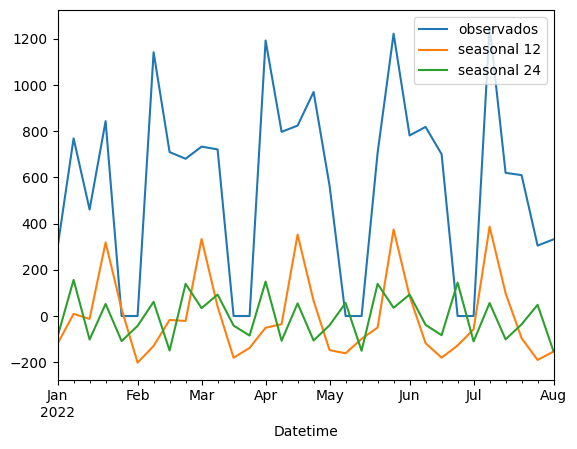

In [ ]:
# Graficar datos observados con datos de estacionalidad
ax = res2.observed.plot(label='observados')

res2.seasonal['seasonal_6'].plot(ax=ax, label='seasonal 12')
res2.seasonal['seasonal_12'].plot(ax=ax, label='seasonal 24')

plt.legend()
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, LSTM, Dropout, BatchNormalization
import matplotlib.pyplot as plt
import numpy as np

# Primer modelo: CNN con LSTM
model_cnn_lstm = keras.Sequential([
    Conv1D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=(X.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.5),
    Conv1D(filters=64, kernel_size=3, padding="same", activation="relu"),
    MaxPooling1D(pool_size=2),
    Dropout(0.5),
    LSTM(units=128, return_sequences=True),
    LSTM(units=64),
    BatchNormalization(),
    Dropout(0.5),
    Flatten(),
    Dense(units=128, activation="relu"),
    Dense(units=64, activation="relu"),
    Dense(units=1, activation="linear"),
])

# Segundo modelo: MLP
model_mlp = keras.Sequential([
    Dense(128, activation='relu', input_shape=(X.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])
# Compilación de los modelos
model_cnn_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_mlp.compile(optimizer='adam', loss='mean_squared_error')


In [ ]:
# Entrenamiento de los modelos
history_cnn_lstm = model_cnn_lstm.fit(X, y, epochs=500, validation_split=0.2)

Epoch 1/500
2/2 [==============================] - 6s 794ms/step - loss: 101706.1953 - val_loss: 84644.1016
Epoch 2/500
2/2 [==============================] - 0s 34ms/step - loss: 101291.2266 - val_loss: 84606.2500
Epoch 3/500
2/2 [==============================] - 0s 33ms/step - loss: 101059.6484 - val_loss: 84565.1875
Epoch 4/500
2/2 [==============================] - 0s 33ms/step - loss: 100593.1562 - val_loss: 84530.3516
Epoch 5/500
2/2 [==============================] - 0s 32ms/step - loss: 100251.0859 - val_loss: 84488.3828
Epoch 6/500
2/2 [==============================] - 0s 33ms/step - loss: 99724.2500 - val_loss: 84440.5547
Epoch 7/500
2/2 [==============================] - 0s 32ms/step - loss: 99405.0391 - val_loss: 84383.3594
Epoch 8/500
2/2 [==============================] - 0s 33ms/step - loss: 98752.6641 - val_loss: 84322.5078
Epoch 9/500
2/2 [==============================] - 0s 32ms/step - loss: 98362.6875 - val_loss: 84252.2266
Epoch 10/500
2/2 [======================

In [ ]:
evaluation_cnn_lstm = model_cnn_lstm.evaluate(X, y)
evaluation_mlp = model_mlp.evaluate(X, y)

2/2 [==============================] - 0s 4ms/step - loss: 510881.1875


In [ ]:
history_mlp = model_mlp.fit(X, y, epochs=20, validation_split=0.01)

Epoch 1/20
2/2 [==============================] - 0s 74ms/step - loss: 11470670.0000 - val_loss: 134589.6250
Epoch 2/20
2/2 [==============================] - 0s 28ms/step - loss: 12877417.0000 - val_loss: 348731.6250
Epoch 3/20
2/2 [==============================] - 0s 27ms/step - loss: 16576886.0000 - val_loss: 161956.5000
Epoch 4/20
2/2 [==============================] - 0s 28ms/step - loss: 12675080.0000 - val_loss: 27066.1445
Epoch 5/20
2/2 [==============================] - 0s 28ms/step - loss: 9264323.0000 - val_loss: 73059.7109
Epoch 6/20
2/2 [==============================] - 0s 28ms/step - loss: 10030911.0000 - val_loss: 171759.6562
Epoch 7/20
2/2 [==============================] - 0s 29ms/step - loss: 9123068.0000 - val_loss: 304554.5000
Epoch 8/20
2/2 [==============================] - 0s 28ms/step - loss: 7918028.0000 - val_loss: 583111.0000
Epoch 9/20
2/2 [==============================] - 0s 40ms/step - loss: 7349138.5000 - val_loss: 962195.2500
Epoch 10/20
2/2 [========

In [ ]:

predictions_cnn_lstm = model_cnn_lstm.predict(X)
predictions_mlp = model_mlp.predict(X)

2/2 [==============================] - 0s 3ms/step


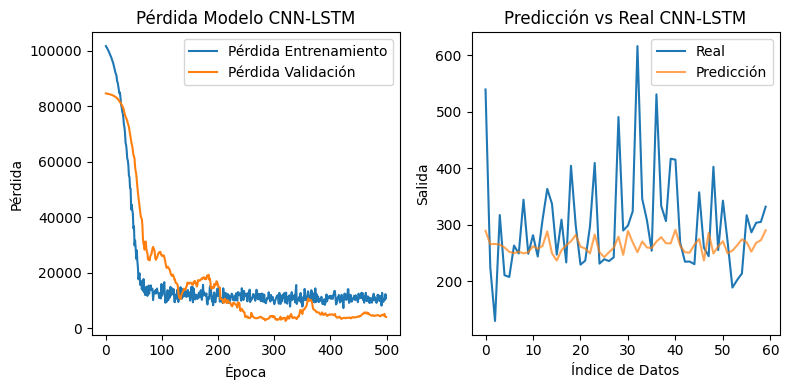

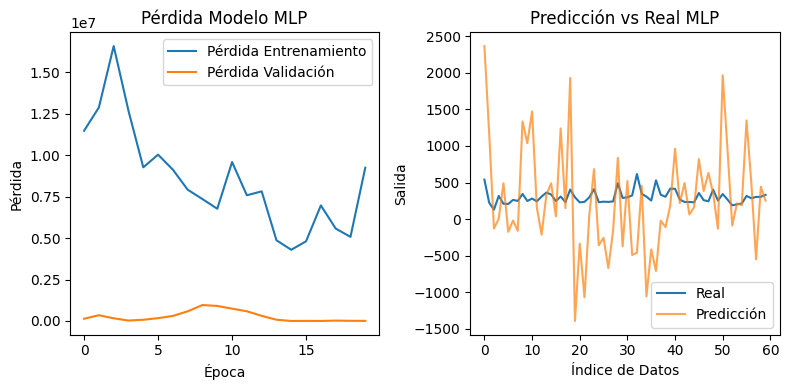

In [ ]:
# Gráficas de entrenamiento y validación para CNN-LSTM
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(history_cnn_lstm.history['loss'], label='Pérdida Entrenamiento')
plt.plot(history_cnn_lstm.history['val_loss'], label='Pérdida Validación')
plt.title('Pérdida Modelo CNN-LSTM')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

# Gráficas de predicciones vs valores reales para CNN-LSTM
plt.subplot(1, 2, 2)
plt.plot(y, label='Real')
plt.plot(predictions_cnn_lstm.flatten(), label='Predicción', alpha=0.7)
plt.title('Predicción vs Real CNN-LSTM')
plt.xlabel('Índice de Datos')
plt.ylabel('Salida')
plt.legend()

plt.tight_layout()
plt.show()

# Gráficas de entrenamiento y validación para MLP
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(history_mlp.history['loss'], label='Pérdida Entrenamiento')
plt.plot(history_mlp.history['val_loss'], label='Pérdida Validación')
plt.title('Pérdida Modelo MLP')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

# Gráficas de predicciones vs valores reales para MLP
plt.subplot(1, 2, 2)
plt.plot(y, label='Real')
plt.plot(predictions_mlp, label='Predicción', alpha=0.7)
plt.title('Predicción vs Real MLP')
plt.xlabel('Índice de Datos')
plt.ylabel('Salida')
plt.legend()

plt.tight_layout()
plt.show()

# Parte 3 Clasificación

## Occupancy Detection

### [Link del Dataset](https://archive.ics.uci.edu/dataset/357/occupancy+detection)

Experimental data used for binary classification (room occupancy) from Temperature, Humidity, Light and CO2. Ground-truth occupancy was obtained from time stamped pictures that were taken every minute.

Dataset Characteristics
Multivariate, Time-Series

Associated Tasks
Classification

Feature Type: Real

- Instances
20560

- Features
6

| Variable | Role | Type | Description | Units | Missing Values |
| --- | --- | --- | --- | --- | --- |
| id | ID | Integer |  |  | no |
| date | Feature | Date |  |  | no |
| Temperature | Feature | Integer |  |  | no |
| Humidity | Feature | Continuous |  | % | no |
| Light | Feature | Integer |  | Lux | no |

Variables information:

date time year-month-day hour:minute:second

Temperature, in Celsius

Relative Humidity, %

Light, in Lux

CO2, in ppm

Humidity Ratio, Derived quantity from temperature and relative humidity, in
kgwater-vapor/kg-air

Occupancy, 0 or 1, 0 for not occupied, 1 for occupied status



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#loading the datasets
df1 = pd.read_csv('/content/drive/MyDrive/ProyectoPronosticos/datatest.txt')
df2 = pd.read_csv('/content/drive/MyDrive/ProyectoPronosticos/datatraining.txt')

#combining the datasets
df = pd.concat([df1, df2])
df.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
140,2015-02-02 14:19:00,23.7000,26.272,585.200000,749.200000,0.004764,1
141,2015-02-02 14:19:59,23.7180,26.290,578.400000,760.400000,0.004773,1
142,2015-02-02 14:21:00,23.7300,26.230,572.666667,769.666667,0.004765,1
143,2015-02-02 14:22:00,23.7225,26.125,493.750000,774.750000,0.004744,1
144,2015-02-02 14:23:00,23.7540,26.200,488.600000,779.000000,0.004767,1


## Data Preprocessing

In [ ]:
#number of rows and columns
df.shape

(10808, 7)

In [ ]:
#checking for null values
df.isnull().sum()

date             0
Temperature      0
Humidity         0
Light            0
CO2              0
HumidityRatio    0
Occupancy        0
dtype: int64

In [ ]:
#removing the duplicate values
df.drop_duplicates(inplace=True)

In [ ]:
#checking data types
df.dtypes

date              object
Temperature      float64
Humidity         float64
Light            float64
CO2              float64
HumidityRatio    float64
Occupancy          int64
dtype: object

In [ ]:
#converting the date and time to datetime format
df['date'] = pd.to_datetime(df['date'])

In [ ]:
df.dtypes

date             datetime64[ns]
Temperature             float64
Humidity                float64
Light                   float64
CO2                     float64
HumidityRatio           float64
Occupancy                 int64
dtype: object

In [ ]:
#checking the descriptive statistics
df.describe()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,10808,10808.000000,10808.000000,10808.000000,10808.00000,10808.000000,10808.000000
mean,2015-02-06 13:44:12.396003072,20.819992,25.638407,137.694088,634.00507,0.003903,0.249907
min,2015-02-02 14:19:00,19.000000,16.745000,0.000000,412.75000,0.002674,0.000000
25%,2015-02-04 18:27:45,20.000000,21.390000,0.000000,441.00000,0.003323,0.000000
50%,2015-02-06 15:29:29.500000,20.700000,25.680000,0.000000,464.00000,0.003805,0.000000
75%,2015-02-08 12:31:14.249999872,21.500000,28.324167,413.541667,761.00000,0.004372,0.000000
max,2015-02-10 09:33:00,24.408333,39.117500,1697.250000,2028.50000,0.006476,1.000000
std,NaN,1.078410,4.953792,212.175483,312.81727,0.000803,0.432979


In [ ]:
#value counts for the target variable i.e. occupancy
df['Occupancy'].value_counts()

Occupancy
0    8107
1    2701
Name: count, dtype: int64

### EDA

####  Lineplot for Themperature Changes for Time

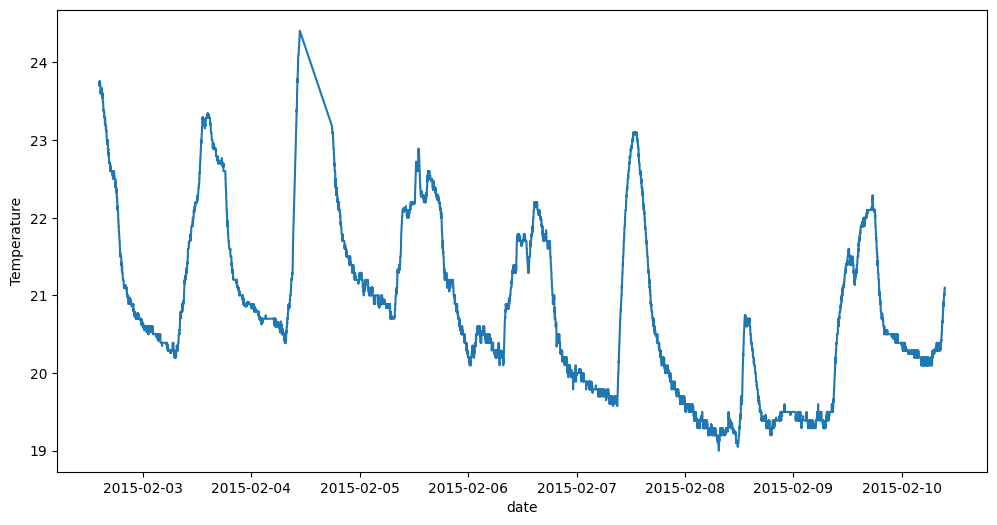

In [ ]:
plt.figure(figsize = (12, 6))
sns.lineplot(x = 'date', y = 'Temperature', data = df)
plt.show()

#### Lineplot for Humidity Changes for Time

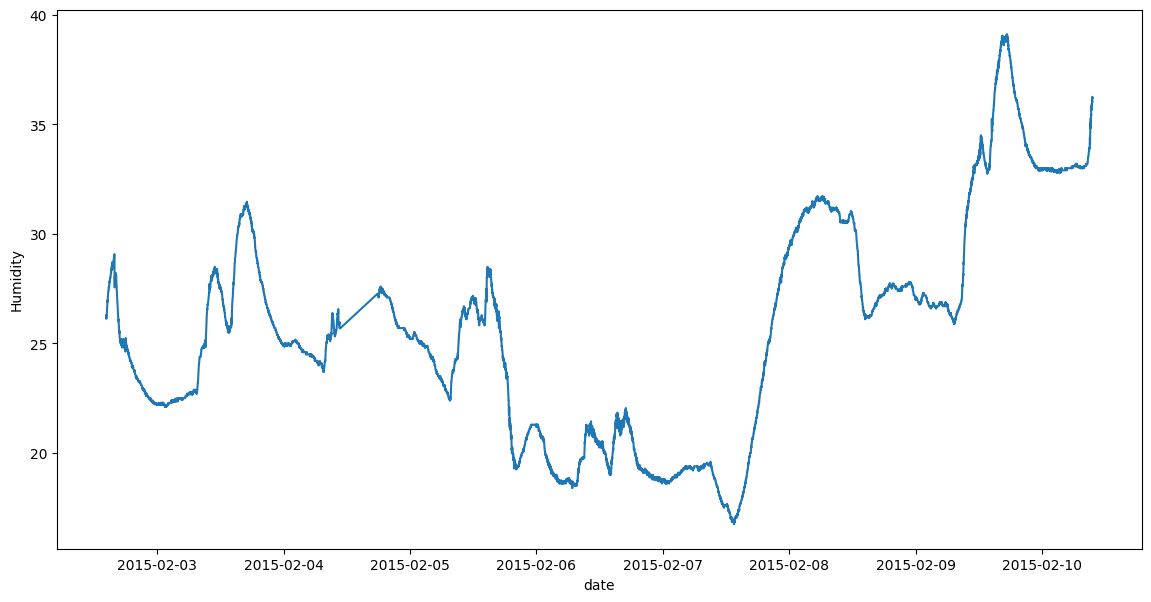

In [ ]:
plt.figure(figsize = (12, 6))
sns.lineplot(x = 'date', y = 'Humidity', data = df)
plt.show()

#### Visualizing the light fluctuations over time

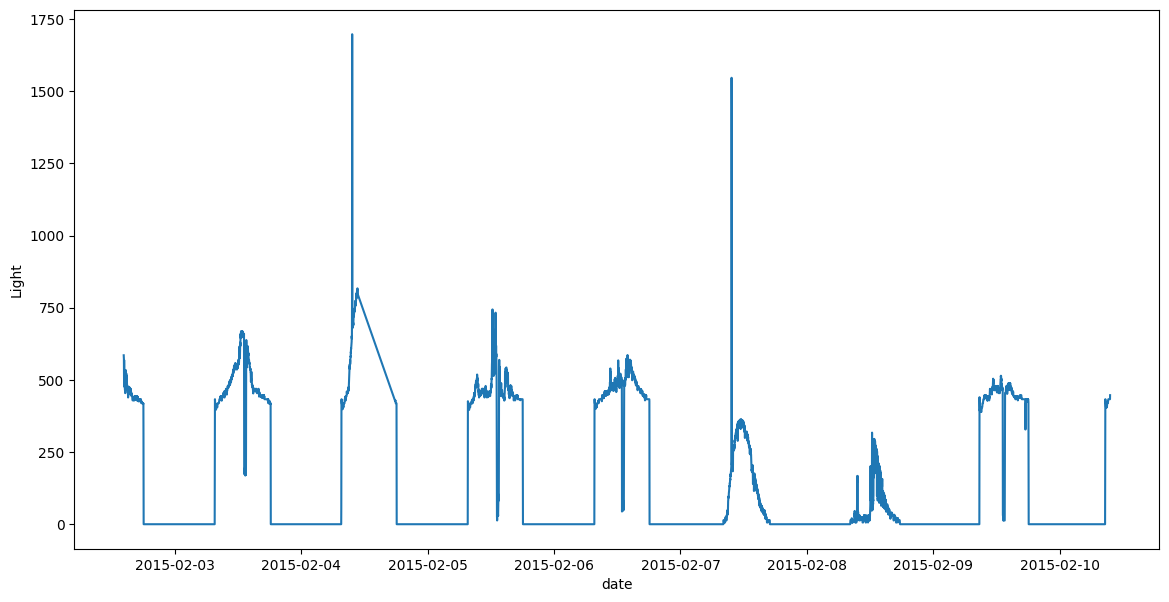

In [ ]:
plt.figure(figsize = (12, 6))
sns.lineplot(x = 'date', y = 'Light', data = df)
plt.show()

#### Visualizing the CO2 fluctuations over time

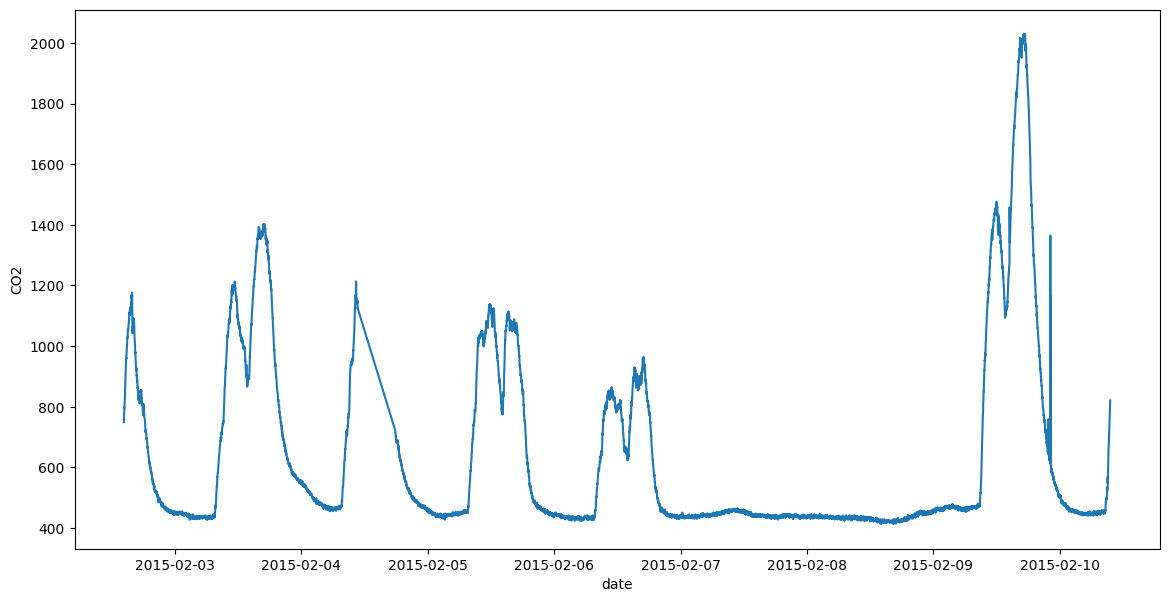

In [ ]:
plt.figure(figsize = (12, 6))
sns.lineplot(x = 'date',y = 'CO2', data = df)
plt.show()

#### Visualizing the humidity ratio fluctuations over time

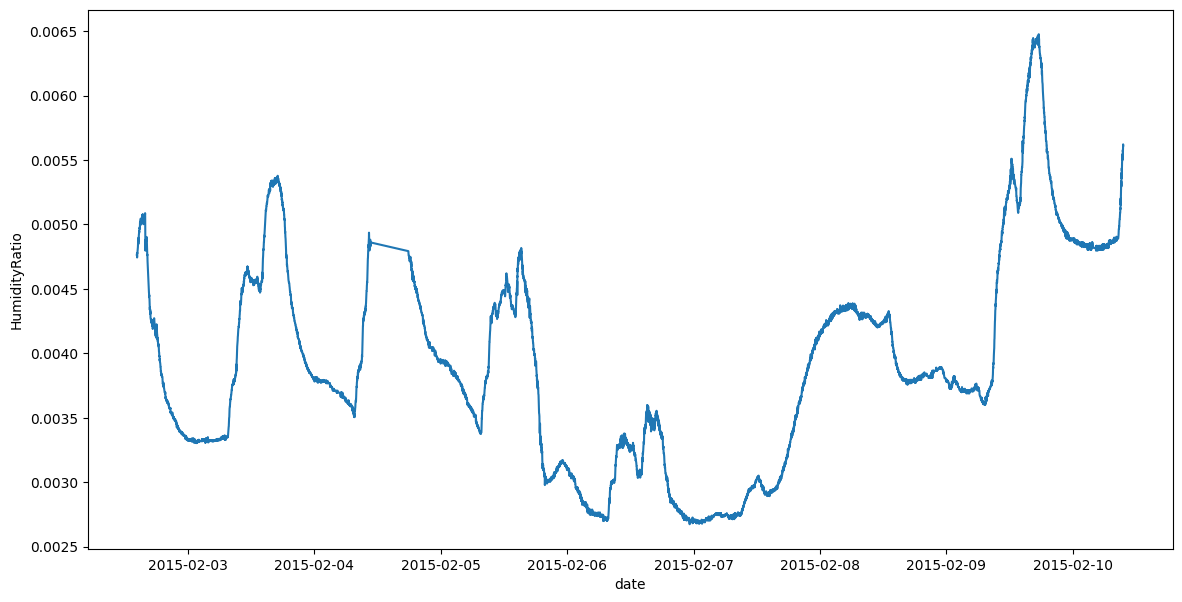

In [ ]:
plt.figure(figsize = (12, 6))
sns.lineplot(x = 'date', y = 'HumidityRatio', data = df)
plt.show()

### Correlation Between the Variables

#### Correlation Heatmap

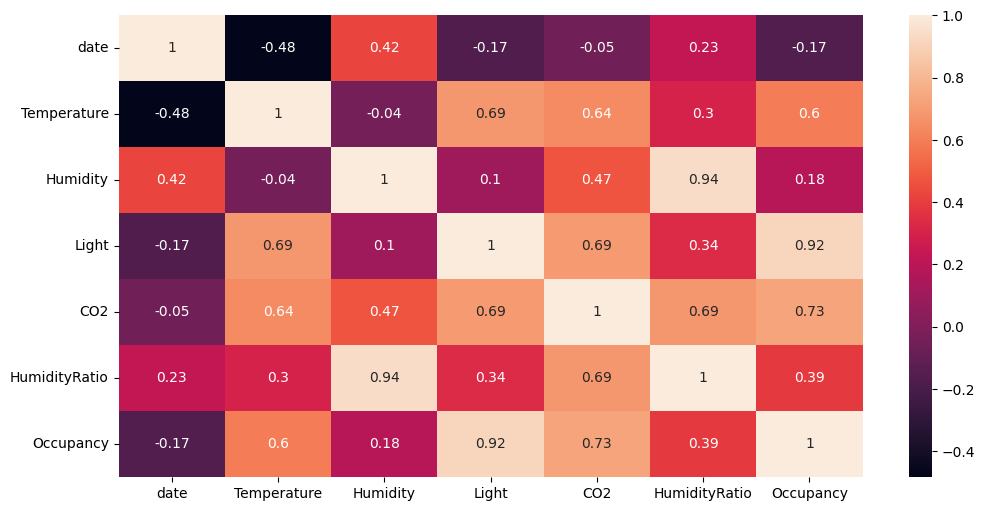

In [ ]:
plt.figure(figsize = (12, 6))
sns.heatmap(df.corr(), annot = True)
plt.show()

#### Temperature and Occupancy

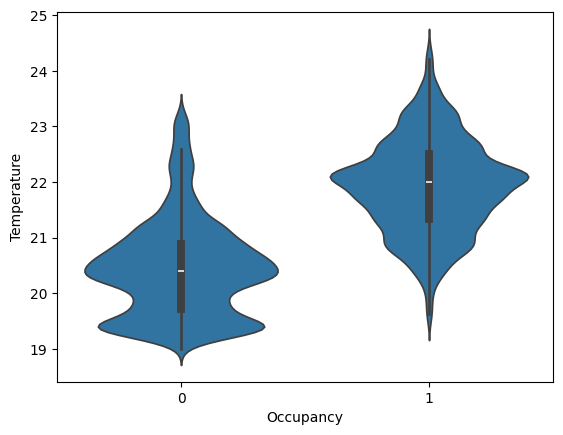

In [ ]:
sns.violinplot(y = df['Temperature'], x = df['Occupancy'])
plt.xlabel('Occupancy')
plt.ylabel('Temperature')
plt.show()

#### Light and Occupancy

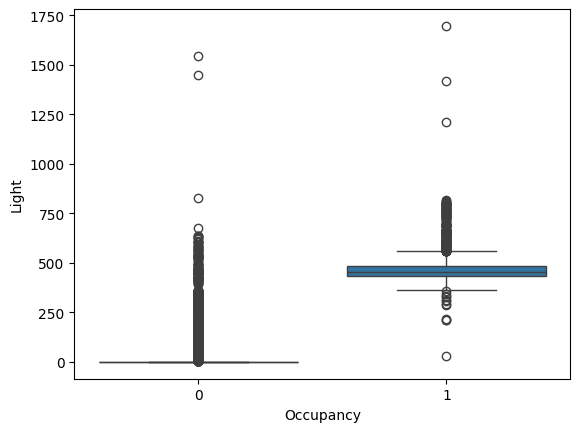

In [ ]:
sns.boxplot(y = df['Light'], x = df['Occupancy'])
plt.xlabel('Occupancy')
plt.ylabel('Light')
plt.show()

#### CO2 and Occupancy

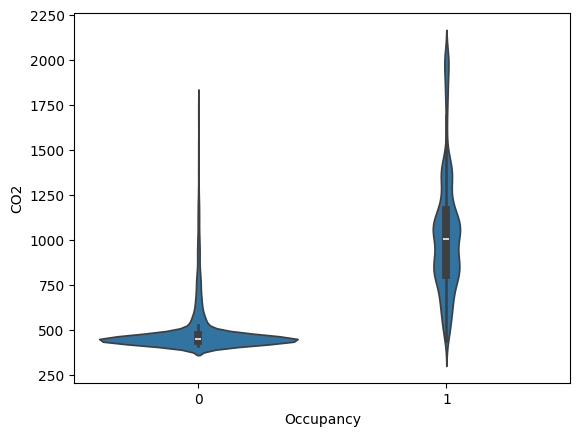

In [ ]:
sns.violinplot(y = df['CO2'], x = df['Occupancy'])
plt.xlabel('Occupancy')
plt.ylabel('CO2')
plt.show()

## Data Preprocessing 2

In [ ]:
df.drop(['Humidity', 'date', 'HumidityRatio'], axis = 1, inplace = True)

In [ ]:
df.head(10)

,Temperature,Light,CO2,Occupancy
140,23.7000,585.200000,749.200000,1
141,23.7180,578.400000,760.400000,1
142,23.7300,572.666667,769.666667,1
143,23.7225,493.750000,774.750000,1
144,23.7540,488.600000,779.000000,1
145,23.7600,568.666667,790.000000,1
146,23.7300,536.333333,798.000000,1
147,23.7540,509.000000,797.000000,1
148,23.7540,476.000000,803.200000,1
149,23.7360,510.000000,809.000000,1


## Train, Test Split

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.drop(['Occupancy'], axis = 1), df['Occupancy'], test_size = 0.2, random_state = 42)

## Model Building

#### Random Tree Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc

RandomForestClassifier()

In [ ]:
#training the model
rfc.fit(x_train, y_train)

#training accuracy
rfc.score(x_train, y_train)

1.0

### Model Evaluation


In [ ]:
rfc_pred = rfc.predict(x_test)

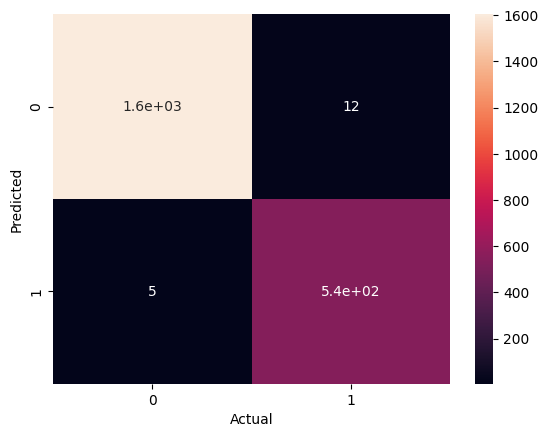

In [ ]:
from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(y_test, rfc_pred), annot = True)
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.show()

<ipython-input-36-c98603061a7b>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(y_test,hist=False,label='Actual', color='r')
<ipython-input-36-c98603061a7b>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfc_pred,hist=False,label='Predicted',color='b',ax=ax)


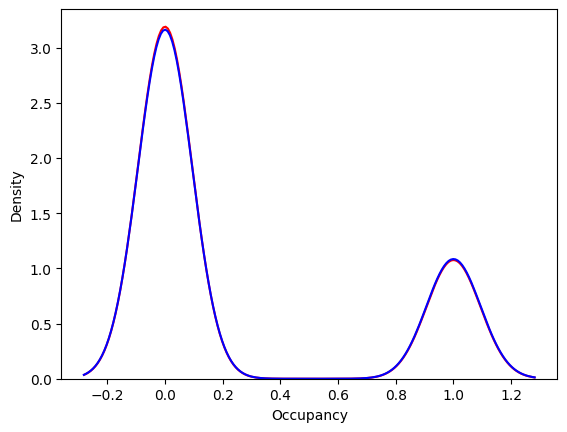

In [ ]:
ax = sns.distplot(y_test, hist = False, label = 'Actual', color = 'r')
sns.distplot(rfc_pred, hist = False, label = 'Predicted', color = 'b', ax = ax)
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, rfc_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1617
           1       0.98      0.99      0.98       545

    accuracy                           0.99      2162
   macro avg       0.99      0.99      0.99      2162
weighted avg       0.99      0.99      0.99      2162



In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [ ]:
print('Accuracy Score : ' + str(accuracy_score(y_test,rfc_pred)))
print('Precision Score : ' + str(precision_score(y_test,rfc_pred)))
print('Recall Score : ' + str(recall_score(y_test,rfc_pred)))
print('F1 Score : ' + str(f1_score(y_test,rfc_pred)))

Accuracy Score : 0.9921369102682701
Precision Score : 0.9782608695652174
Recall Score : 0.9908256880733946
F1 Score : 0.9845031905195989


## Testing the Model on New Dataset

In [ ]:
df_new = pd.read_csv('/content/drive/MyDrive/ProyectoPronosticos/datatest2.txt')
df_new.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-11 14:48:00,21.7600,31.133333,437.333333,1029.666667,0.005021,1
2,2015-02-11 14:49:00,21.7900,31.000000,437.333333,1000.000000,0.005009,1
3,2015-02-11 14:50:00,21.7675,31.122500,434.000000,1003.750000,0.005022,1
4,2015-02-11 14:51:00,21.7675,31.122500,439.000000,1009.500000,0.005022,1
5,2015-02-11 14:51:59,21.7900,31.133333,437.333333,1005.666667,0.005030,1


In [ ]:
df_new.drop(['Humidity', 'date', 'HumidityRatio'], axis = 1, inplace = True)

In [ ]:
x = df_new.drop(['Occupancy'], axis = 1)
y = df_new['Occupancy']

In [ ]:
pred = rfc.predict(x)

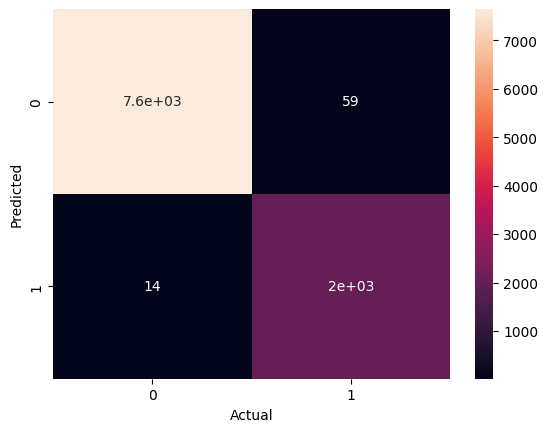

In [ ]:
sns.heatmap(confusion_matrix(y, pred),annot = True)
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.show()

<ipython-input-45-2b449d355d71>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(y,hist=False,label='Actual', color='r')
<ipython-input-45-2b449d355d71>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pred,hist=False,label='Predicted',color='b',ax=ax)


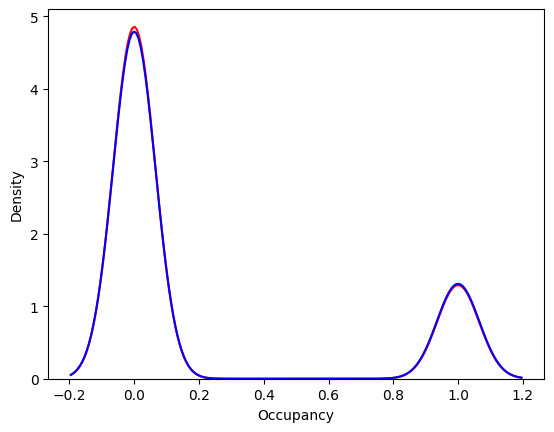

In [ ]:
ax = sns.distplot(y,hist=False,label='Actual', color='r')
sns.distplot(pred,hist=False,label='Predicted',color='b',ax=ax)
plt.show()

In [ ]:
print(classification_report(y,pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      7703
           1       0.97      0.99      0.98      2049

    accuracy                           0.99      9752
   macro avg       0.98      0.99      0.99      9752
weighted avg       0.99      0.99      0.99      9752



In [ ]:
print('Accuracy Score : ' + str(accuracy_score(y,pred)))
print('Precision Score : ' + str(precision_score(y,pred)))
print('Recall Score : ' + str(recall_score(y,pred)))
print('F1 Score : ' + str(f1_score(y,pred)))

Accuracy Score : 0.9925143560295324
Precision Score : 0.9718242597898759
Recall Score : 0.9931673987310884
F1 Score : 0.9823799179338643
